<a href="https://colab.research.google.com/github/unicamp-dl/IA025_2022S1/blob/main/ex06/karen_rosero/Aula_6_Exerc%C3%ADcio_Template_KarenRosero.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Treinamento de uma CNN no CIFAR 10

In [94]:
nome = 'Karen Rosero'

print(f'Meu nome é {nome}')

Meu nome é Karen Rosero


Este exercicío consiste em implementar e treinar no CIFAR-10 vários blocos de uma Resnet seguido de uma camada linear de classificação.

## Importação das bibliotecas

In [95]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import random
import torch
import torchvision
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST

## Fixando as seeds

In [96]:
random.seed(123)
np.random.seed(123)
torch.manual_seed(123)

## Dataset e dataloader

### Definição do tamanho do minibatch

In [97]:
batch_size = 50

## Download do CIFAR-10

In [98]:
!mkdir ./data

transform = torchvision.transforms.Compose(
    [torchvision.transforms.ToTensor(),
     torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                             download=True, transform=transform)

test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                            download=True, transform=transform)


mkdir: cannot create directory ‘./data’: File exists
Files already downloaded and verified
Files already downloaded and verified


## Criação do dataloader

In [99]:
train_size = 40000
val_size = 10000
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [train_size, val_size])

In [100]:
batch_size = 50

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print('Número de minibatches de trenamento:', len(train_dataloader))
print('Número de minibatches de validação:', len(val_dataloader))
print('Número de minibatches de teste:', len(test_dataloader))

x_train, y_train = next(iter(train_dataloader))
print("\nDimensões dos dados de um minibatch:", x_train.size())
print("Valores mínimo e máximo dos pixels: ", torch.min(x_train), torch.max(x_train))
print("Tipo dos dados das imagens:         ", type(x_train))
print("Tipo das classes das imagens:       ", type(y_train))

Número de minibatches de trenamento: 800
Número de minibatches de validação: 200
Número de minibatches de teste: 200

Dimensões dos dados de um minibatch: torch.Size([50, 3, 32, 32])
Valores mínimo e máximo dos pixels:  tensor(-1.) tensor(1.)
Tipo dos dados das imagens:          <class 'torch.Tensor'>
Tipo das classes das imagens:        <class 'torch.Tensor'>


## Implementando o Bloco Básico da Resnet

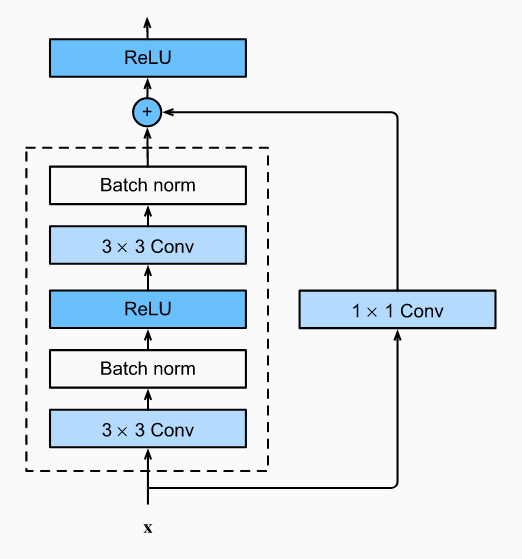

In [101]:
from torch import nn
from torch import Tensor

class MyBasicBlock(nn.Module):

    def __init__(self, inplanes: int, planes: int, stride: int = 1,) -> None: #return annotation None
        super(MyBasicBlock, self).__init__()
        # camada 3x3 conv. Output-> n_samples=batch=50, filters=planes=64, H=W=((shape+2p-3)/stride)+1
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=3, stride=stride,
                     padding=(1,1), groups=1, bias=False, dilation=1)
        # camada batch normalization
        self.bn1 = nn.BatchNorm2d(planes)
        # função de ativação ReLU
        self.relu = nn.ReLU()
        # segunda camada 3x3 conv. Output-> n_samples=batch=50, filters=planes=64, H=W=((shape+2p-3)/1)+1
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1,
                     padding=(1,1), groups=1, bias=False, dilation=1)
        # segunda camada batch normalization
        self.bn2 = nn.BatchNorm2d(planes)

        # conv 1x1 da shortcut connection. Precisa ter o mesmo nome e parâmetros 
        # da linha do bloco seguinte 'downsample'
        # Com isso consegue ter a mesma dimensão na entrada que vai ser adicionada a saída do bloco
        self.downsample = nn.Conv2d(inplanes, planes, kernel_size=1, stride=2,
                     padding=0, groups=1, bias=False, dilation=1)        

    def forward(self, x: Tensor) -> Tensor: #garante que o return vai ser um tensor
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        # adicionando o bloco processado com a entrada x
        out += self.downsample(x)
        out = self.relu(out)

        return out


## Compare se sua implementação está igual à do pytorch usando um exemplo aleatório

In [102]:
import torchvision

height_in = 5
width_in = 5
inplanes = 2
planes = 3
stride = 2

x = torch.rand(1, inplanes, height_in, width_in)
# Input (batch=1, channels = 2, H = 5, W = 5)

block = MyBasicBlock(inplanes=inplanes, planes=planes, stride=stride)
# Output (batch = 1, planes = 3, H = (5+2-3)/2 +1 = 3, W = (5+2-2)/2 +1 = 3)

# mesmos parâmetros de downsample usados para conv1x1 no MyBasicBlock
downsample = nn.Conv2d(inplanes, planes, kernel_size=1, stride=stride, padding=0, groups=1, bias=False, dilation=1)
block_pt = torchvision.models.resnet.BasicBlock(inplanes=inplanes, planes=planes, stride=stride, downsample=downsample)

# Usa os mesmos pesos para minha implementação e a do pytorch
block.load_state_dict(block_pt.state_dict())

out = block(x)
target_out = block_pt(x)

print(f'out shape:\n{out.shape}') 
print(f'target shape:\n{target_out.shape}') 

print(f'out:\n{out}')
print(f'target_out:\n{target_out}')

assert torch.allclose(out, target_out, atol=1e-6)

out shape:
torch.Size([1, 3, 3, 3])
target shape:
torch.Size([1, 3, 3, 3])
out:
tensor([[[[0.2084, 0.0000, 0.1053],
          [1.2176, 1.7145, 0.0000],
          [2.1509, 0.0000, 0.0000]],

         [[0.0000, 1.4478, 0.0000],
          [0.0000, 0.0000, 0.0000],
          [0.6579, 0.5231, 0.0000]],

         [[0.0000, 0.8983, 1.1205],
          [0.0000, 0.0000, 0.0225],
          [0.0000, 0.8017, 0.5681]]]], grad_fn=<ReluBackward0>)
target_out:
tensor([[[[0.2084, 0.0000, 0.1053],
          [1.2176, 1.7145, 0.0000],
          [2.1509, 0.0000, 0.0000]],

         [[0.0000, 1.4478, 0.0000],
          [0.0000, 0.0000, 0.0000],
          [0.6579, 0.5231, 0.0000]],

         [[0.0000, 0.8983, 1.1205],
          [0.0000, 0.0000, 0.0225],
          [0.0000, 0.8017, 0.5681]]]], grad_fn=<ReluBackward0>)


## Modelo

Implemente um modelo de classificação que será treinado no CIFAR-10.

In [135]:
class Net(torch.nn.Module):
    def __init__(self, ):
        super(Net, self).__init__()
        #Input (50,3,32,32)
        self.MBB1 = MyBasicBlock(inplanes=3, planes=32, stride = stride)
        # output (50,32,(32+2-3)/2 +1, (32+2-3)/2 +1) = (50,32,16,16)
        self.MBB2 = MyBasicBlock(inplanes=32, planes=64, stride = stride)
        # output (50,64,(16+2-3)/2 +1, (16+2-3)/2 +1) = (50,64,8,8)
        self.MBB3 = MyBasicBlock(inplanes=64, planes=128, stride = stride)
        # output (50,128,(8+2-3)/2 +1, (8+2-3)/2 +1) = (50,128,4,4)
        self.pool = nn.AvgPool2d((2,2))
        # output (50,128,(8-3)/2 +1, (8-3)/2 +1) = (50,128,2,2)
        self.dense1 = nn.Linear(128*2*2,128) 
        self.relu = nn.ReLU()
        self.dense2 = nn.Linear(128, 10) 

    def forward(self, x):
        # Escreva seu código aqui.
        out = self.MBB1(x)
        out = self.MBB2(out)
        out = self.MBB3(out)
        out = self.pool(out)
        out = out.view(-1, 128*2*2)
        out = self.dense1(out)
        out = self.relu(out)
        out = self.dense2(out)
        
        return out

## Treinamento

### Definição dos hiperparâmetros

In [119]:
n_epochs = 20
lr = 0.01

### Detectando a GPU

In [105]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [136]:
def evaluation(model, loader):
    # Escreva seu código aqui.
    TP = 0
    N = 0
    model.eval()
    with torch.no_grad():
      # declaro loader semelhante com o do treinamento, usando tqdm
      for x, y in tqdm(loader, total=len(loader), desc='Validation'):
        predicted = model(x.to(device))
        probs = torch.softmax(predicted, dim=1)
        max_prob = torch.argmax(probs, dim=1)
        y = y.to(device)
        TP += y[y == max_prob].shape[0] 
        N += x.to(device).shape[0] 
        mean_accuracy = TP / N
    print(f'Accuracy: {mean_accuracy}')

### Laço de treinamento

In [137]:
from tqdm import tqdm


model = Net()

model.to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr)

epochs = []
loss_history = []
loss_epoch_end = []
total_trained_samples = 0

# Primeira avaliação com pesos aleatórios
evaluation(model=model, loader=val_dataloader)

for i in range(n_epochs):
    model.train()
    for x_train, y_train in tqdm(train_dataloader, total=len(train_dataloader), desc='Training'):
        x_train = x_train.to(device)
        y_train = y_train.to(device)

        # predict da rede
        outputs = model(x_train)

        # calcula a perda
        loss = criterion(outputs, y_train)

        # zero, backpropagation, ajusta parâmetros pelo gradiente descendente
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_trained_samples += x_train.size(0)
        epochs.append(total_trained_samples / len(train_dataset))
        loss_history.append(loss.item())

    loss_epoch_end.append(loss.item())
    print(f'Epoch: {i:d}/{n_epochs - 1:d} Loss: {loss.item()}')

    # Chama a função de validação no final de cada época
    evaluation(model=model, loader=val_dataloader)

Validation: 100%|██████████| 200/200 [00:04<00:00, 43.23it/s]


Accuracy: 0.1012


Training: 100%|██████████| 800/800 [00:30<00:00, 26.66it/s]


Epoch: 0/19 Loss: 1.5413388013839722


Validation: 100%|██████████| 200/200 [00:04<00:00, 43.64it/s]


Accuracy: 0.4398


Training: 100%|██████████| 800/800 [00:30<00:00, 25.95it/s]


Epoch: 1/19 Loss: 1.1342154741287231


Validation: 100%|██████████| 200/200 [00:04<00:00, 44.08it/s]


Accuracy: 0.534


Training: 100%|██████████| 800/800 [00:30<00:00, 26.59it/s]


Epoch: 2/19 Loss: 1.140832781791687


Validation: 100%|██████████| 200/200 [00:04<00:00, 43.60it/s]


Accuracy: 0.5786


Training: 100%|██████████| 800/800 [00:30<00:00, 26.58it/s]


Epoch: 3/19 Loss: 0.9558892846107483


Validation: 100%|██████████| 200/200 [00:04<00:00, 43.60it/s]


Accuracy: 0.6074


Training: 100%|██████████| 800/800 [00:29<00:00, 26.78it/s]


Epoch: 4/19 Loss: 0.7734243273735046


Validation: 100%|██████████| 200/200 [00:04<00:00, 43.72it/s]


Accuracy: 0.6629


Training: 100%|██████████| 800/800 [00:29<00:00, 26.74it/s]


Epoch: 5/19 Loss: 0.8061888813972473


Validation: 100%|██████████| 200/200 [00:04<00:00, 43.65it/s]


Accuracy: 0.6572


Training: 100%|██████████| 800/800 [00:30<00:00, 26.61it/s]


Epoch: 6/19 Loss: 0.6491599082946777


Validation: 100%|██████████| 200/200 [00:04<00:00, 43.81it/s]


Accuracy: 0.6927


Training: 100%|██████████| 800/800 [00:29<00:00, 26.70it/s]


Epoch: 7/19 Loss: 0.6483655571937561


Validation: 100%|██████████| 200/200 [00:04<00:00, 44.16it/s]


Accuracy: 0.6761


Training: 100%|██████████| 800/800 [00:29<00:00, 26.91it/s]


Epoch: 8/19 Loss: 0.6437788605690002


Validation: 100%|██████████| 200/200 [00:04<00:00, 43.68it/s]


Accuracy: 0.6802


Training: 100%|██████████| 800/800 [00:29<00:00, 27.03it/s]


Epoch: 9/19 Loss: 0.366824746131897


Validation: 100%|██████████| 200/200 [00:04<00:00, 43.65it/s]


Accuracy: 0.6964


Training: 100%|██████████| 800/800 [00:29<00:00, 26.88it/s]


Epoch: 10/19 Loss: 0.5380195379257202


Validation: 100%|██████████| 200/200 [00:04<00:00, 43.09it/s]


Accuracy: 0.6933


Training: 100%|██████████| 800/800 [00:30<00:00, 26.51it/s]


Epoch: 11/19 Loss: 0.23652383685112


Validation: 100%|██████████| 200/200 [00:04<00:00, 43.92it/s]


Accuracy: 0.6928


Training: 100%|██████████| 800/800 [00:29<00:00, 26.88it/s]


Epoch: 12/19 Loss: 0.27736613154411316


Validation: 100%|██████████| 200/200 [00:04<00:00, 43.82it/s]


Accuracy: 0.6955


Training: 100%|██████████| 800/800 [00:29<00:00, 26.76it/s]


Epoch: 13/19 Loss: 0.31171783804893494


Validation: 100%|██████████| 200/200 [00:04<00:00, 43.83it/s]


Accuracy: 0.6997


Training: 100%|██████████| 800/800 [00:29<00:00, 26.83it/s]


Epoch: 14/19 Loss: 0.29942086338996887


Validation: 100%|██████████| 200/200 [00:04<00:00, 44.17it/s]


Accuracy: 0.6857


Training: 100%|██████████| 800/800 [00:29<00:00, 26.77it/s]


Epoch: 15/19 Loss: 0.09561452269554138


Validation: 100%|██████████| 200/200 [00:04<00:00, 44.13it/s]


Accuracy: 0.6875


Training: 100%|██████████| 800/800 [00:29<00:00, 26.90it/s]


Epoch: 16/19 Loss: 0.04396091774106026


Validation: 100%|██████████| 200/200 [00:04<00:00, 44.13it/s]


Accuracy: 0.6849


Training: 100%|██████████| 800/800 [00:29<00:00, 26.89it/s]


Epoch: 17/19 Loss: 0.22356803715229034


Validation: 100%|██████████| 200/200 [00:04<00:00, 43.36it/s]


Accuracy: 0.6891


Training: 100%|██████████| 800/800 [00:29<00:00, 26.85it/s]


Epoch: 18/19 Loss: 0.1007193773984909


Validation: 100%|██████████| 200/200 [00:04<00:00, 44.25it/s]


Accuracy: 0.6881


Training: 100%|██████████| 800/800 [00:29<00:00, 26.89it/s]


Epoch: 19/19 Loss: 0.05184260010719299


Validation: 100%|██████████| 200/200 [00:04<00:00, 44.12it/s]

Accuracy: 0.6965


### Visualização usual da perda, somente no final de cada minibatch

Text(0.5, 0, 'época')

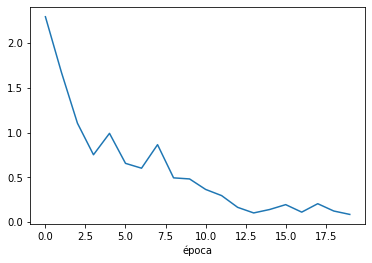

In [138]:
n_batches_train = len(train_dataloader)
plt.plot(epochs[::n_batches_train], loss_history[::n_batches_train])
plt.xlabel('época')

## Avaliação final no dataset de testes

In [139]:
evaluation(model=model, loader=test_dataloader)

Validation: 100%|██████████| 200/200 [00:04<00:00, 42.74it/s]

Accuracy: 0.7062


# Bonus Opcional

## Implementando o Dropout

In [ ]:
class MyDropout(torch.nn.Module):
    def __init__(self, p: float):
        # Escreva seu código aqui.

    def forward(self, x: Tensor, training: bool):
        # Escreva seu código aqui.
        return out

## Mostre que sua implementação traz resultados semelhantes à implementação do pytorch

In [ ]:
import math

p = 0.5
dropout = MyDropout(p=p)

x = torch.rand(16, 3, 32, 32)

out = dropout(x, training=True)
out_pt = torch.nn.functional.dropout(x, p=p, training=True)

mean_zeros = (out == 0).sum() / out.numel()
mean_zeros_pt = (out_pt == 0).sum() / out_pt.numel()

print(f'mean zeros: {mean_zeros}')
print(f'mean zeros pytorch: {mean_zeros_pt}')

assert math.isclose(mean_zeros, mean_zeros_pt, abs_tol=1e-2)

out = dropout(x, training=False)
target_out = torch.nn.functional.dropout(x, p=p, training=False, inplace=False)
assert torch.allclose(out, target_out, atol=1e-6)